In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# sns支持中文
# 设置seaborn支持中文
sns.set(font='SimHei')


# 设置图表样式
sns.set(style="whitegrid")
plt.style.use('ggplot')

In [16]:
tag_map = {}
# 读取 craft2025_pearcat/run/sample_practice_map_1.txt
with open('../run/sample_practice_map_1.txt', 'r') as f:
    for line in f:
        req_id, tag = map(int, line.strip().split())
        tag_map[req_id] = tag
# 支持中文

## 读取输入文件

首先读取sample_practice.in文件并解析其内容

In [17]:
# 定义函数用于解析输入文件
def parse_input(filepath):
    objects = {}  # 存储所有对象信息：{obj_id: {'birth': timestamp, 'death': timestamp, 'size': size, 'tag': tag}}
    object_operations = []  # 存储对象操作序列：[(timestamp, operation, obj_id, obj_size, obj_tag), ...]
    
    with open(filepath, 'r') as f:
        # 读取第一行基本参数
        T, M, N, V, G, K = map(int, f.readline().strip().split())
        
        # 跳过频率数组（3*M行）
        for _ in range(3*M):
            f.readline()
        
        # 处理每个时间片的输入
        current_timestamp = 0
        
        # 最多读取T+10^5个时间片或直到文件结束
        while current_timestamp < T + 105:
            line = f.readline().strip()
            if not line:  # 文件结束
                break
                
            # 时间片对齐事件
            if line.startswith("TIMESTAMP"):
                current_timestamp = int(line.split()[1])
                
                # 对象删除事件
                n_delete = int(f.readline().strip())
                for _ in range(n_delete):
                    obj_id = int(f.readline().strip())
                    if obj_id in objects:
                        objects[obj_id]['death'] = current_timestamp
                        object_operations.append((current_timestamp, 'delete', obj_id, objects[obj_id]['size'], objects[obj_id]['tag']))
                
                # 对象写入事件
                n_write = int(f.readline().strip())
                for _ in range(n_write):
                    obj_info = f.readline().strip().split()
                    obj_id, obj_size, obj_tag = map(int, obj_info)
                    objects[obj_id] = {
                        'birth': current_timestamp,
                        'death': None,  # 初始设为None，表示对象尚未删除
                        'size': obj_size,
                        'tag': obj_tag
                    }
                    if objects[obj_id]['tag'] ==0:
                        assert(tag_map[obj_id] in tag_map)
                        objects[obj_id]['tag'] = tag_map[obj_id]
                        obj_tag = tag_map[obj_id]
                        
                    object_operations.append((current_timestamp, 'write', obj_id, obj_size, obj_tag))
                
                # 对象读取事件
                n_read = int(f.readline().strip())
                for _ in range(n_read):
                    req_info = f.readline().strip().split()
                    req_id, obj_id = map(int, req_info)
                    if obj_id in objects:
                        object_operations.append((current_timestamp, 'read', obj_id, objects[obj_id]['size'], objects[obj_id]['tag']))
    
    # 处理那些在最后还没有被删除的对象
    for obj_id, obj_info in objects.items():
        if obj_info['death'] is None:
            obj_info['death'] = T + 105  # 设置为最大时间片
    
    return T, M, N, V, G, objects, object_operations

# 解析输入文件
filepath = '../run/sample_practice_1.in'
T, M, N, V, G, objects, object_operations = parse_input(filepath)

print(f"总时间片数: {T}")
print(f"对象标签数: {M}")
print(f"硬盘数: {N}")
print(f"每个硬盘的存储单元数: {V}")
print(f"每个磁头每时间片的最大令牌数: {G}")
print(f"总对象数: {len(objects)}")

总时间片数: 86400
对象标签数: 16
硬盘数: 10
每个硬盘的存储单元数: 16384
每个磁头每时间片的最大令牌数: 345
总对象数: 41442


## 随时间各标签的文件状态变化

统计各个标签随时间的未删除文件数量、新增文件数量和删除文件数量。

In [26]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 定义时间区间
interval_size = 1800
num_intervals = (T + 105) // interval_size + 1
intervals = [(i*interval_size, min((i+1)*interval_size, T+105)) for i in range(num_intervals)]

# 初始化数据结构
tag_intervals = {tag: {i: {'active': 0, 'new': 0, 'deleted': 0, 'total_size': 0} for i in range(num_intervals)} for tag in range(1, M+1)}
all_intervals = {i: {'active': 0, 'new': 0, 'deleted': 0, 'total_size': 0} for i in range(num_intervals)}


# 计算每个时间区间内各标签的文件状态
for obj_id, obj_info in objects.items():
    birth = obj_info['birth']
    death = obj_info['death']
    tag = obj_info['tag']
    size = obj_info['size']
    
    # 计算对象创建和删除所在的区间
    birth_interval = birth // interval_size
    death_interval = death // interval_size if death is not None else num_intervals - 1
    
    # 记录新增文件
    if birth_interval < num_intervals:
        tag_intervals[tag][birth_interval]['new'] += 1
        all_intervals[birth_interval]['new'] += 1
    
    # 记录删除文件
    if death_interval < num_intervals and death is not None:
        tag_intervals[tag][death_interval]['deleted'] += 1
        all_intervals[death_interval]['deleted'] += 1
    
    # 更新每个区间的活跃文件数
    for i in range(birth_interval, min(death_interval + 1, num_intervals)):
        tag_intervals[tag][i]['active'] += 1
        all_intervals[i]['active'] += 1
        tag_intervals[tag][i]['total_size'] += size
        all_intervals[i]['total_size'] += size

# 统计每个标签的最大活跃文件大小
max_active_size_by_tag = {}
for tag in range(1, M+1):
    max_active_size = max([tag_intervals[tag][interval]['total_size'] for interval in range(num_intervals)])
    max_active_size_by_tag[tag] = max_active_size

# 打印比例
# 计算所有标签的最大活跃文件大小总和
total_max_active_size = sum(max_active_size_by_tag.values())

# 打印每个标签的最大活跃文件大小占比

read_rate = []
for tag, max_size in max_active_size_by_tag.items():
    percentage = (max_size / total_max_active_size) * 100 if total_max_active_size > 0 else 0
    read_rate.append(percentage*1e3//1/1e5)


In [27]:
# 初始化读取、删除和请求数量的统计
read_counts = {tag: [0] * num_intervals for tag in range(1, M+1)}
delete_counts = {tag: [0] * num_intervals for tag in range(1, M+1)}
request_counts = {tag: [0] * num_intervals for tag in range(1, M+1)}

# 统计每个时间区间内各标签的读取、删除和请求数量
for op in object_operations:
    timestamp, operation, obj_id, obj_size, obj_tag = op
    interval_idx = timestamp // interval_size
    
    if interval_idx < num_intervals:
        if operation == 'read':
            read_counts[obj_tag][interval_idx] += 1
            request_counts[obj_tag][interval_idx] += 1
        elif operation == 'delete':
            delete_counts[obj_tag][interval_idx] += 1
            request_counts[obj_tag][interval_idx] += 1
        elif operation == 'write':
            request_counts[obj_tag][interval_idx] += 1
            
print("\n每个标签的最大活跃文件大小占比：")
print(str(read_rate))

# 打印每1800周期的读数量（二维数组，每行为一个tag）
print("\n每1800周期的读数量（按标签）：")
read_array = []
for tag in range(1, M+1):
    read_array.append(read_counts[tag])
print(str(read_array))

# 打印每1800周期的删数量（二维数组，每行为一个tag）
print("\n每1800周期的删数量（按标签）：")
delete_array = []
for tag in range(1, M+1):
    delete_array.append(delete_counts[tag])
print(str(delete_array))

# 打印每1800周期的请求数量（二维数组，每行为一个tag）
print("\n每1800周期的请求数量（按标签）：")
request_array = []
for tag in range(1, M+1):
    request_array.append(request_counts[tag])
print(str(request_array))


每个标签的最大活跃文件大小占比：
[0.04294, 0.05094, 0.07206, 0.06001, 0.13109, 0.05974, 0.04092, 0.03887, 0.05502, 0.06854, 0.04131, 0.1375, 0.04064, 0.06147, 0.04098, 0.0579]

每1800周期的读数量（按标签）：
[[734, 707, 592, 452, 302, 188, 10484, 28554, 43780, 55311, 60364, 59864, 53265, 41411, 25559, 15661, 34833, 59149, 80129, 96387, 107562, 112707, 111300, 103506, 94207, 118732, 115691, 60859, 3224, 382, 537, 695, 740, 677, 532, 348, 222, 148, 184, 315, 455, 639, 704, 693, 607, 447, 7460, 12941, 0], [560, 654, 565, 474, 317, 192, 140, 190, 293, 416, 584, 635, 604, 494, 402, 2839, 19689, 37579, 58790, 74670, 77978, 65834, 45667, 48297, 97280, 137525, 115445, 63163, 50061, 71008, 90987, 105856, 110797, 104537, 88896, 68573, 47409, 29741, 12506, 283, 400, 531, 698, 635, 529, 574, 10710, 9529, 0], [453, 270, 162, 166, 244, 392, 598, 655, 722, 641, 505, 327, 205, 157, 181, 303, 471, 624, 678, 671, 570, 397, 265, 143, 158, 5995, 39492, 99835, 149066, 140034, 99279, 69792, 55926, 53521, 52465, 63230, 81453, 94927, 10

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

[0.04294, 0.05094, 0.07206, 0.06001, 0.13109, 0.05974, 0.04092, 0.03887, 0.05502, 0.06854, 0.04131, 0.1375, 0.04064, 0.06147, 0.04098, 0.0579]


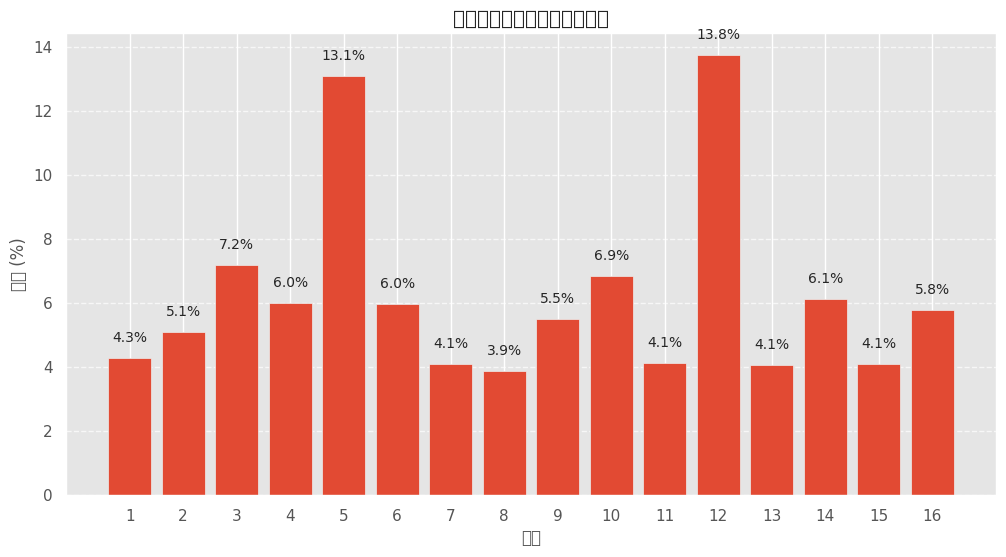

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

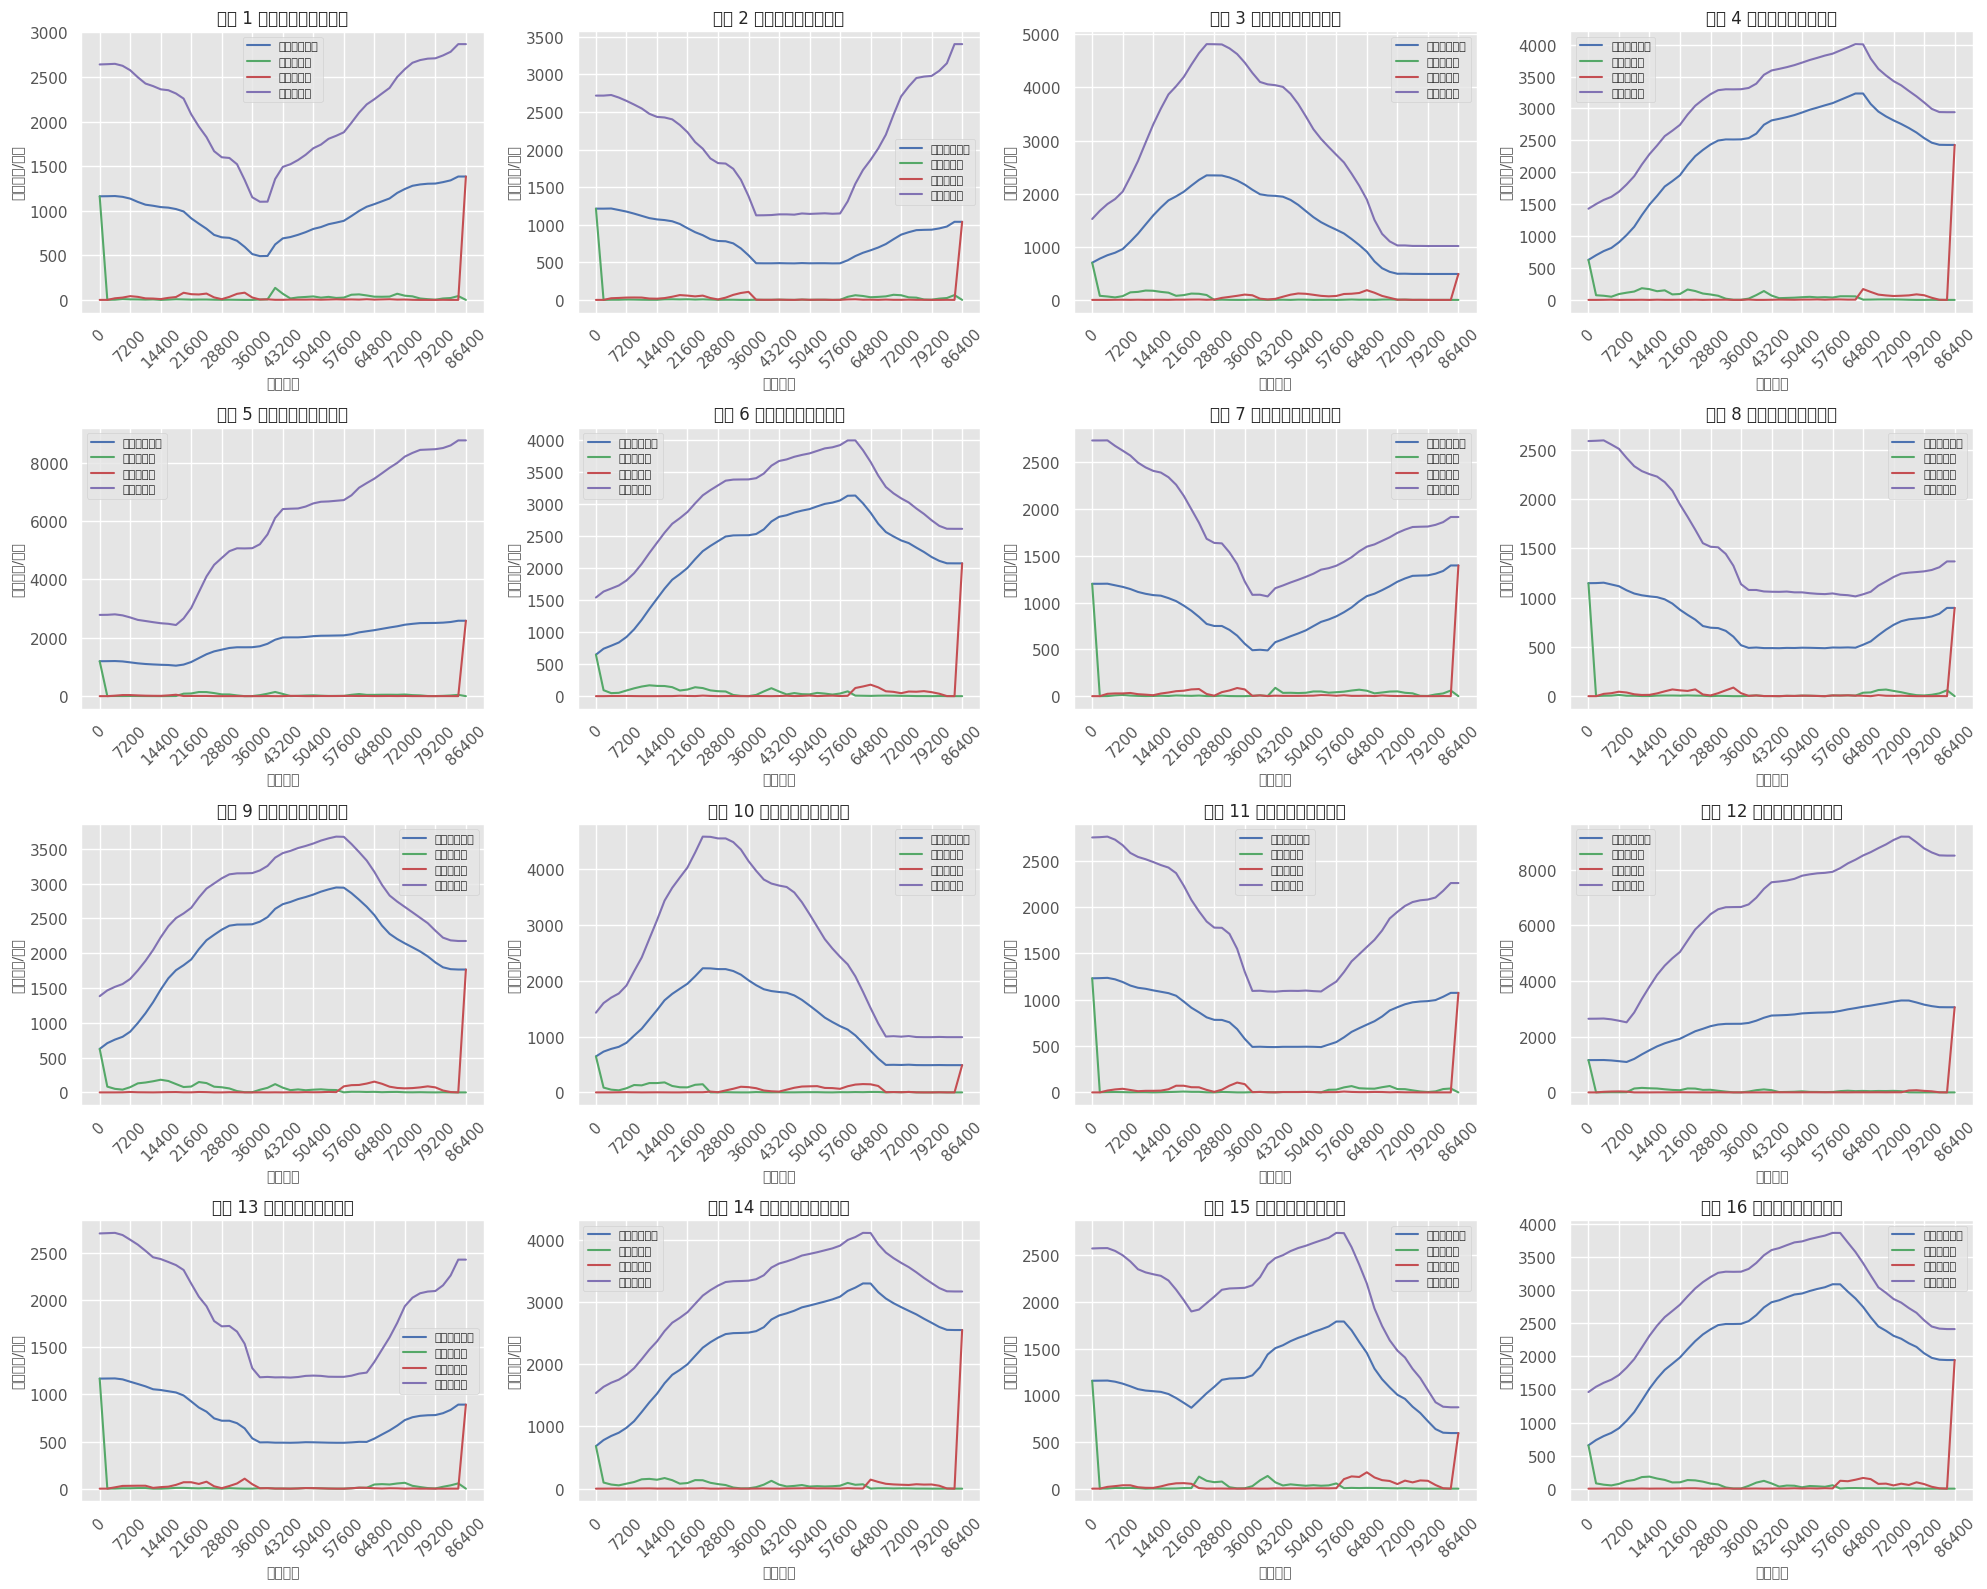

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

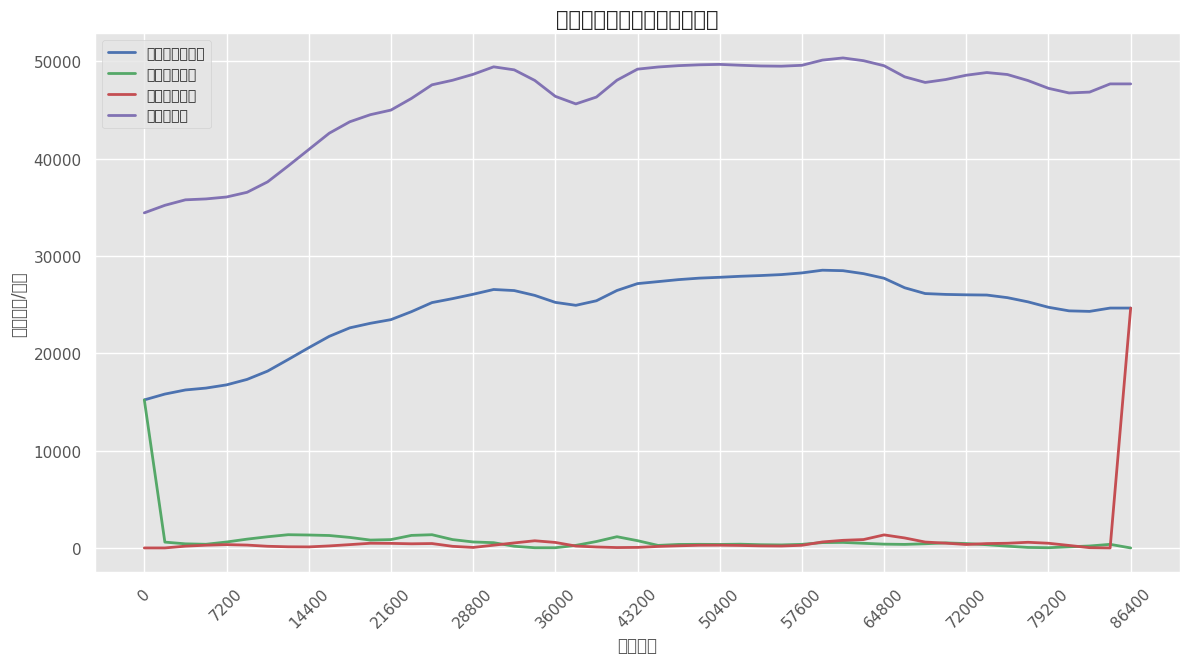

In [19]:
# 可视化标签占比
plt.figure(figsize=(12, 6))
tags = list(max_active_size_by_tag.keys())
sizes = list(max_active_size_by_tag.values())
percentages = [(size / total_max_active_size)*1e5//1/1e5 for size in sizes]
print(str(percentages))
percentages = [_*100 for _ in percentages]


plt.bar(tags, percentages)
plt.xlabel('标签')
plt.ylabel('占比 (%)')
plt.title('各标签最大活跃文件大小占比')
plt.xticks(tags)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, p in enumerate(percentages):
    plt.text(tags[i], p + 0.5, f'{p:.1f}%', ha='center')

plt.show()


# 准备可视化数据
interval_labels = [f"{i*interval_size}" for i in range(num_intervals)]
x = list(range(num_intervals))

# 为每个标签创建图表
fig, axs = plt.subplots(4, 4, figsize=(20, 16))
axs = axs.flatten()

for i in range(1, M+1):
    active_counts = [tag_intervals[i][interval]['active'] for interval in range(num_intervals)]
    new_counts = [tag_intervals[i][interval]['new'] for interval in range(num_intervals)]
    deleted_counts = [tag_intervals[i][interval]['deleted'] for interval in range(num_intervals)]
    total_size = [tag_intervals[i][interval]['total_size'] for interval in range(num_intervals)]
    
    ax = axs[i-1]
    ax.plot(x, active_counts, 'b-', label='未删除文件数')
    ax.plot(x, new_counts, 'g-', label='新增文件数')
    ax.plot(x, deleted_counts, 'r-', label='删除文件数')
    ax.plot(x, total_size, 'm-', label='总文件大小')
    
    ax.set_title(f'标签 {i} 文件状态随时间变化', fontsize=12)
    ax.set_xlabel('时间区间', fontsize=10)
    ax.set_ylabel('文件数量/大小', fontsize=10)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True)
    
    # 设置x轴标签，但只显示部分以避免拥挤
    if num_intervals > 10:
        step = num_intervals // 10
        ax.set_xticks(x[::step])
        ax.set_xticklabels(interval_labels[::step], rotation=45)
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(interval_labels, rotation=45)

plt.tight_layout()
# plt.savefig('tag_file_status_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

# 创建所有标签总体图表
plt.figure(figsize=(14, 7))
active_counts = [all_intervals[interval]['active'] for interval in range(num_intervals)]
new_counts = [all_intervals[interval]['new'] for interval in range(num_intervals)]
deleted_counts = [all_intervals[interval]['deleted'] for interval in range(num_intervals)]
total_size = [all_intervals[interval]['total_size'] for interval in range(num_intervals)]

plt.plot(x, active_counts, 'b-', linewidth=2, label='未删除文件总数')
plt.plot(x, new_counts, 'g-', linewidth=2, label='新增文件总数')
plt.plot(x, deleted_counts, 'r-', linewidth=2, label='删除文件总数')
plt.plot(x, total_size, 'm-', linewidth=2, label='总文件大小')

plt.title('所有标签文件状态随时间变化', fontsize=15)
plt.xlabel('时间区间', fontsize=12)
plt.ylabel('文件数量/大小', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True)

if num_intervals > 10:
    step = num_intervals // 10
    plt.xticks(x[::step], interval_labels[::step], rotation=45)
else:
    plt.xticks(x, interval_labels, rotation=45)

# plt.savefig('all_file_status_over_time.png', dpi=300, bbox_inches='tight')
plt.show()